In [1]:
%load_ext Cython

In [2]:
%%cython

import numpy as np
cimport numpy as np
import cython

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import pickle

# Input plot

In [5]:
with open('tests/timestream/ground_template_filter_array_input.pkl', 'rb') as f:
    ground_template_filter_array_input = pickle.load(f, encoding='latin1')
with open('tests/timestream/ground_template_filter_array_output.pkl', 'rb') as f:
    ground_template_filter_array_output = pickle.load(f, encoding='latin1')

In [6]:
input_array, az, mask, pixel_size, groundmap, lr, filtmask = ground_template_filter_array_input

In [7]:
input_array.shape

(1, 10508)

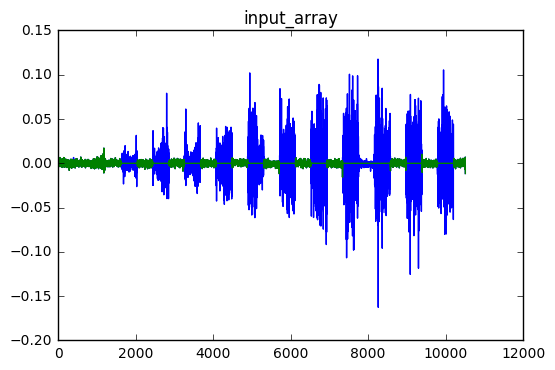

In [8]:
plt.title('input_array')
plt.plot(input_array[0], label='input_array')

plt.plot(input_array[0] * filtmask[0], label='masked')

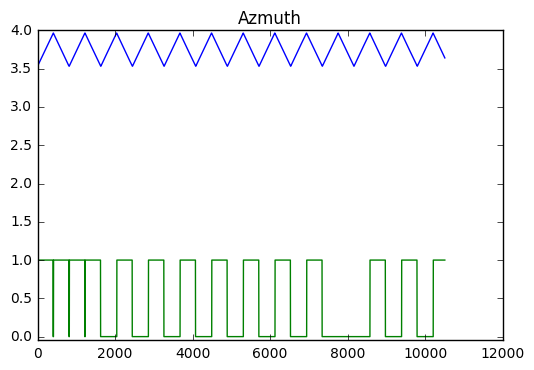

In [9]:
plt.title('Azmuth')
plt.plot(az)
axes = plt.gca()
axes.set_ylim([-0.05,4])
plt.plot(filtmask[0])

# Output

In [10]:
# epsilon
7./3 - 4./3 - 1

2.220446049250313e-16

# Code

In [54]:
%%cython --annotate

import numpy as np # --compile-args=-fopenmp --link-args=-fopenmp
cimport numpy as np
import cython

from cython.view cimport array as cvarray
from cpython cimport bool
from cython.parallel import parallel, prange

from libc.math cimport round
from libc.stdlib cimport malloc, free

from numpy.math cimport INFINITY

@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline double max(double[:] x):
    cdef double max = -INFINITY
    for i in range(x.shape[0]):
        if x[i] > max:
            max = x[i]
    return max

@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline double min(double[:] x):
    cdef double min = INFINITY
    for i in range(x.shape[0]):
        if x[i] < min:
            min = x[i]
    return min

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def ground_template_filter_array(
        double[:, :] input_array,
        double[:] az,
        np.ndarray[np.uint8_t, cast=True, ndim=2] mask,
        double pixel_size,
        bool groundmap=False,
        bool lr=False,
        np.ndarray[np.uint8_t, cast=True, ndim=2] filtmask=None):
    '''
    Remove ground template from array timestreams

    Parameters
    ----------
    input_array: array_like
        shape: (number of channels, number of time steps)
        Input timestream, mutated inplace.
    az: array_like
        shape: input_array[0]
        The azimuth of the timestream.
    mask: array_like
        shape: input_array
        dtype: bool
    pixel_size: float
    groundmap: bool
        If groundmap = True, then do the exact opposite,
        and remove component from timestream that isn't fixed with the ground
    lr: bool
        If true, ground substraction done separately on left and right moving scans
    filtmask: array_like
        shape: input_array
        dtype: bool
        default: None
        filtmask is preprocessed from mask and addtional masking e.g. from point source
        In largepatch filtmask refers to wafermask_chan_filt
    '''
    # initialize
    if filtmask is not None:
        mask = filtmask
    cdef int nCh = input_array.shape[0]
    cdef int nTime = input_array.shape[1]
    cdef double az_min = min(az)
    cdef double az_range = max(az) - az_min
    # Calculate number of pixels given the pixel size
    cdef int nPix = <int>round(az_range / pixel_size)

    # get pointing: an array where each elements is the n-th bin
    # beaware of the (n+1)-th bin that needs to be dealt with separately
    cdef Py_ssize_t* pointing = <Py_ssize_t*>malloc(nTime * sizeof(Py_ssize_t))
#     pointing_init = cvarray(shape=(nTime,), itemsize=sizeof(Py_ssize_t), format="i")
#     cdef Py_ssize_t[:] pointing = pointing_init
    cdef double nPix_per_range = nPix / az_range
    cdef Py_ssize_t i, j
    for i in range(nTime):
        # possible values: [0, 1, ..., nPix]
        pointing[i] = <Py_ssize_t>((az[i] - az_min) * nPix_per_range)

    # bins are arrays of pixels
    cdef int nBin = nPix + 1
    # the signal
#     bins_signal = cvarray(shape=(nCh, nBin), itemsize=sizeof(double), format="i")
#     bins_signal[...] = 0
#     # number of hits of signals
#     bins_hit = cvarray(shape=(nCh, nBin), itemsize=sizeof(int), format="i")
#     bins_hit[...] = 0
    cdef double[:, :] bins_signal = np.zeros((nCh, nBin))
    # number of hits of signals
    cdef int[:, :] bins_hit = np.zeros((nCh, nBin), dtype=np.int32)

    cdef Py_ssize_t k
    if not lr:
        # calculate ground template
        # TODO: SIMD
        for i in range(nCh):
            for j in range(nTime):
                if mask[i, j]:
                    k = pointing[j]
                    bins_signal[i, k] += input_array[i, j]
                    bins_hit[i, k] += 1
                    # the following should be better for SIMD, but is slower for me
#                 k = pointing[j]
#                 bins_signal[i, k] += input_array[i, j] * mask[i, j]
#                 bins_hit[i, k] += mask[i, j]
        # TODO: SIMD
        for i in range(nCh, ):
            bins_signal[i, nBin - 2] += bins_signal[i, nBin - 1]
            bins_hit[i, nBin - 2] += bins_hit[i, nBin - 1]
            for j in range(nPix):
                if bins_hit[i, j] != 0:
                    bins_signal[i, j] /= bins_hit[i, j]
        # substraction
        # TODO: check SIMD
        for i in range(nCh, ):
            for j in range(nTime):
                input_array[i, j] -= bins_signal[i, pointing[j]]

    free(pointing)

In [55]:
%%timeit
ground_template_filter_array(output_array, az, mask, pixel_size)

10000 loops, best of 3: 50.2 µs per loop


In [56]:
test_ground_template_filter_array()

((array([[ 0.        ,  0.0032052 ,  0.00404837, ..., -0.0070533 ,
           0.00699448, -0.01087422]]),
  array([ 3.53594566,  3.53711146,  3.53820095, ...,  3.64341665,
          3.64234824,  3.64129303]),
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool),
  0.0013962634015954637,
  False,
  False,
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool)),
 (array([[ 0.        ,  0.0032052 ,  0.00404837, ..., -0.0070533 ,
           0.00699448, -0.01087422]]),
  array([ 3.53594566,  3.53711146,  3.53820095, ...,  3.64341665,
          3.64234824,  3.64129303]),
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool),
  0.0013956848012076121,
  False,
  False,
  array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool)))

# Tests

In [36]:
import numpy as np
from numpy.testing import assert_allclose

def assertIdenticalList(list1, list2):
    for i, list1i in enumerate(list1):
        if isinstance(list1i, bool):
            assert list1i is list2[i]
        else:
            assert_allclose(list1i, list2[i], rtol=1e-03, atol=1e-03)

In [13]:
import pickle
import sys
py2 = sys.version_info[0] == 2


def test_ground_template_filter_array():
    with open('tests/timestream/ground_template_filter_array_input.pkl', 'rb') as f:
        if not py2:
            ground_template_filter_array_input = pickle.load(
                f, encoding='latin1')
        else:
            ground_template_filter_array_input = pickle.load(f)
    with open('tests/timestream/ground_template_filter_array_output.pkl', 'rb') as f:
        if not py2:
            ground_template_filter_array_output = pickle.load(
                f, encoding='latin1')
        else:
            ground_template_filter_array_output = pickle.load(f)
    ground_template_filter_array(*ground_template_filter_array_input)
    assertIdenticalList(
        ground_template_filter_array_input,
        ground_template_filter_array_output)

    # debug
    return ground_template_filter_array_input, ground_template_filter_array_output

In [209]:
import numpy as np

def simulate_ground_input(nCh, nTime, nPixel):
    az_time_width = 400
    az_min = 3.5
    az_max = 4.
    az_range = az_max - az_min

    input_array = (np.random.rand(nCh, nTime) - 0.5) * 0.2

    az = np.array([(az_range * (1 - 
        abs(i % (2 * az_time_width) / float(az_time_width) - 1)) + az_min
        ) for i in range(nTime)])

    mask_half_width = 50
    mask = np.repeat([[(i % az_time_width < mask_half_width
             or i % az_time_width > az_time_width - mask_half_width
            ) for i in range(nTime)]], nCh, axis=0)

    pixel_size = az_range * nPixel

    return input_array, az, mask, pixel_size

In [217]:
tests = simulate_ground_input(3, 10000, 50)

In [219]:
[tests[i].shape for i in range(3)]

[(3, 10000), (10000,), (3, 10000)]

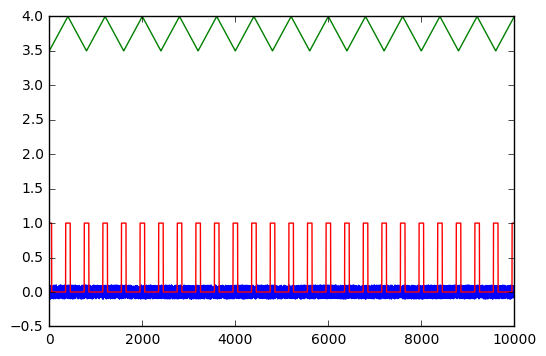

In [222]:
plt.plot(tests[0][0])
plt.plot(tests[1])
plt.plot(tests[2][0])

In [60]:
def time_theoretical(input_array, time_function):
    return time_function(*input_array.shape)

In [65]:
def time_function(m, n):
    FLOP = 4 * m * n + 2 * m + 4 * n + 3
    FLOPS = 8 * 4.5 * 10**9
    time = FLOP / FLOPS
    return time

In [66]:
time_theoretical(input_array, time_function)

2.33525e-06

# Playground

In [14]:
output_array = input_array.copy()

In [15]:
%%timeit
ground_template_filter_array(output_array, az, mask, pixel_size)

10000 loops, best of 3: 55.6 µs per loop


In [16]:
output_array = input_array.copy()
ground_template_filter_array(output_array, az, mask, pixel_size)

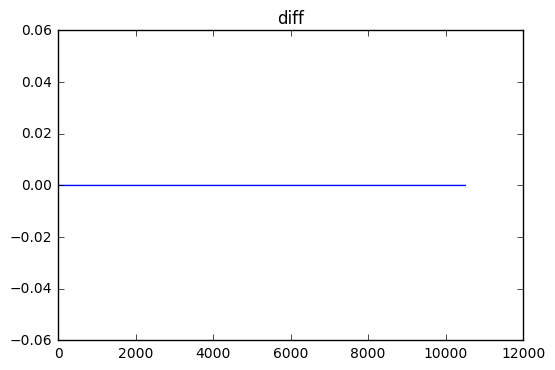

In [17]:
plt.title('diff')
plt.plot(input_array[0] - input_array[0])

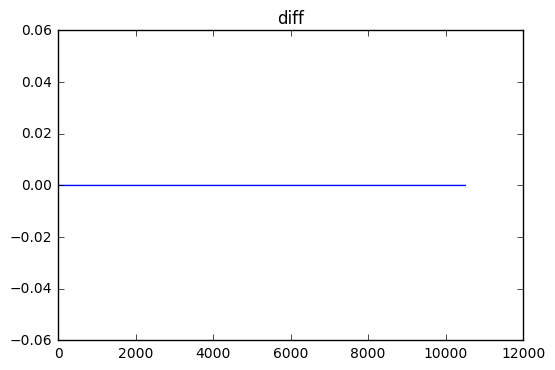

In [18]:
plt.title('diff')
plt.plot(output_array[0] - ground_template_filter_array_output[0][0])